In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
from typing import Callable
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.promptloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.eval.eval_metric import evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({
    # 'font.size': 8,
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True, verbose=False):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        if verbose:
            print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True,
    conversational=False,
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    if conversational:
                        res.append(get_results(f, all_ref_data, iterative_dir="iterative/converse", use_cached=use_cached))
                    else:
                        res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
# print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "Llama-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

In [5]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
  save_png: bool = False,
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12.5, 2 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x="num_examples",
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.1, r'Conversation History Length $L$', ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        if save_png:
            plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [6]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
        df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
    return df

In [7]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset("rotten_tomatoes", rt_reference_data, use_cached=True)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,924,1,1066,mistral-7b,dailymail,0,"[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.220350742340088, -4.32817268371582, -4.091..."
1,892,1,1066,mistral-7b,dailymail,4,None,None,None
2,898,2,1066,mistral-7b,dailymail,2,None,None,None
3,970,0,1066,mistral-7b,rotten_tomatoes,10,None,None,None
4,959,2,1066,mistral-7b,rotten_tomatoes,6,"[-4.686050891876221, -4.661656856536865, -5.04...",None,None


In [8]:
rt_converse_results = get_results_for_evalset(
    "rotten_tomatoes", rt_reference_data, use_cached=True, conversational=True
)

# Flatten columns: history_length_X into {num_examples X, ...metrics}
results = []
for i, res in enumerate(rt_converse_results):
    dataset_keys = [k for k in res.keys() if not k.startswith("history_length")]
    history_length_keys = [k for k in res.keys() if k.startswith("history_length")]
    for hist_key in history_length_keys:
        num_examples = int(hist_key.split("_")[-1])
        d = {k: res[k] for k in dataset_keys}
        d["num_examples"] = num_examples
        d |= res[hist_key]
        results.append(d)

rt_converse_results_df = pd.DataFrame.from_records(results)
# rt_converse_results_df = pd.DataFrame.from_records(rt_converse_results)

# Calculate percentage change
rt_converse_results_df["acc"] = rt_converse_results_df["matches"] / rt_converse_results_df["total"]
rt_converse_results_df = df_metric_pct_change(rt_converse_results_df, "acc")

print(len(rt_converse_results_df))
rt_converse_results_df.head()

56


,model,incontext_set,num_examples,matches,failed,total,acc,acc_pct_change
0,mistral-7b,rotten_tomatoes,0,924,1,1066,0.866792,0.000000
1,mistral-7b,rotten_tomatoes,1,932,6,1066,0.874296,0.865801
2,mistral-7b,rotten_tomatoes,2,949,18,1066,0.890244,2.705628
3,mistral-7b,rotten_tomatoes,3,951,23,1066,0.892120,2.922078
4,mistral-7b,rotten_tomatoes,4,954,19,1066,0.894934,3.246753


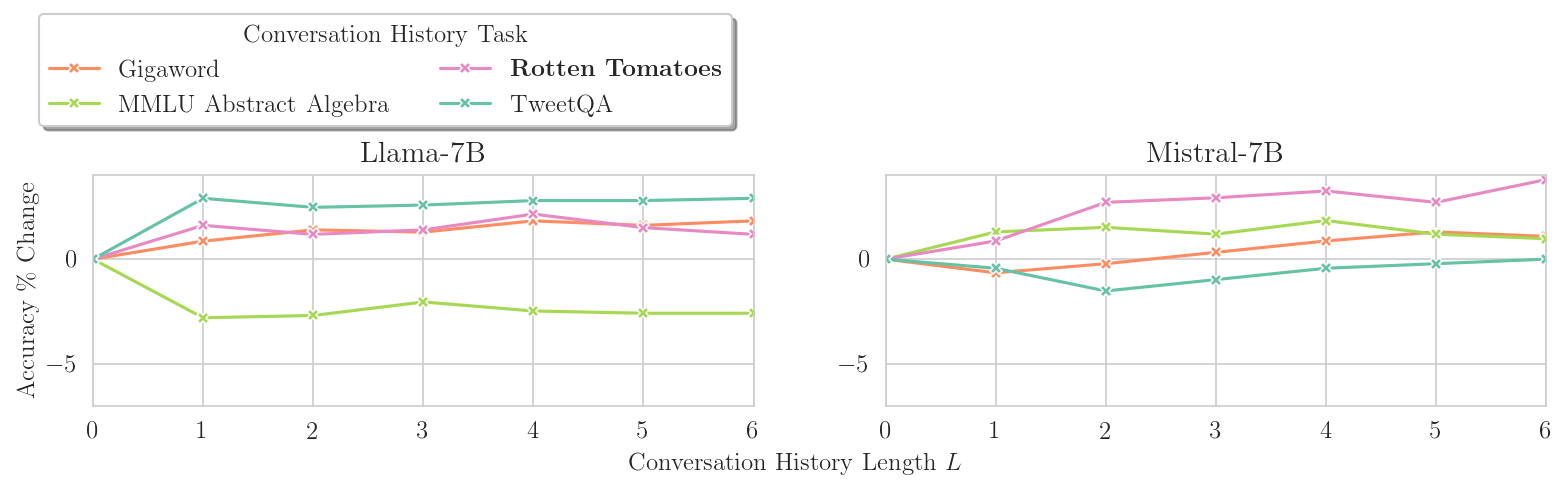

In [9]:
label = r"Accuracy \% Change"
df = rt_converse_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.75),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

### Human Ageing

In [10]:
ha = MMLUHumanAgingDataLoader()
ha_reference_data = ha.load_test_reference()
ha_results = get_results_for_evalset("mmlu-age", ha_reference_data, use_cached=True)
ha_results_df = pd.DataFrame.from_records(ha_results)
ha_results_df.head()

Removing large training set examples
Original training set size:  28
New Training set size:  28


,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,137,1,222,mistral-7b,mmlu-age,3,"[-0.7274147272109985, -1.3350273370742798, -1....",None,None
1,138,2,222,mistral-7b,mmlu-age,6,"[-0.7438650131225586, -1.300289511680603, -1.1...",None,None
2,123,0,222,mistral-7b,mmlu-age,0,"[-0.45550537109375, -1.1860079765319824, -1.09...",None,None
3,140,1,222,mistral-7b,mmlu-age,4,"[-0.6973514556884766, -1.3394109010696411, -1....",None,None
4,135,1,222,mistral-7b,mmlu-age,2,"[-0.6563717722892761, -1.2342803478240967, -1....",None,None


In [14]:
ha_converse_results = get_results_for_evalset("mmlu-age", ha_reference_data, use_cached=True, conversational=True)

# Flatten columns: history_length_X into {num_examples X, ...metrics}
results = []
for i, res in enumerate(ha_converse_results):
    dataset_keys = [k for k in res.keys() if not k.startswith("history_length")]
    history_length_keys = [k for k in res.keys() if k.startswith("history_length")]
    for hist_key in history_length_keys:
        num_examples = int(hist_key.split("_")[-1])
        d = {k: res[k] for k in dataset_keys}
        d["num_examples"] = num_examples
        d |= res[hist_key]
        results.append(d)

ha_converse_results_df = pd.DataFrame.from_records(results)

# Calculate percentage change
ha_converse_results_df["acc"] = ha_converse_results_df["matches"] / ha_converse_results_df["total"]
ha_converse_results_df = df_metric_pct_change(ha_converse_results_df, "acc")

print(len(ha_converse_results_df))
ha_converse_results_df.head()

56


,model,incontext_set,num_examples,matches,failed,total,acc,acc_pct_change
0,mistral-7b,mmlu-age,0,124,0,223,0.556054,0.000000
1,mistral-7b,mmlu-age,1,137,0,223,0.614350,10.483871
2,mistral-7b,mmlu-age,2,145,0,223,0.650224,16.935484
3,mistral-7b,mmlu-age,3,145,0,223,0.650224,16.935484
4,mistral-7b,mmlu-age,4,147,0,223,0.659193,18.548387


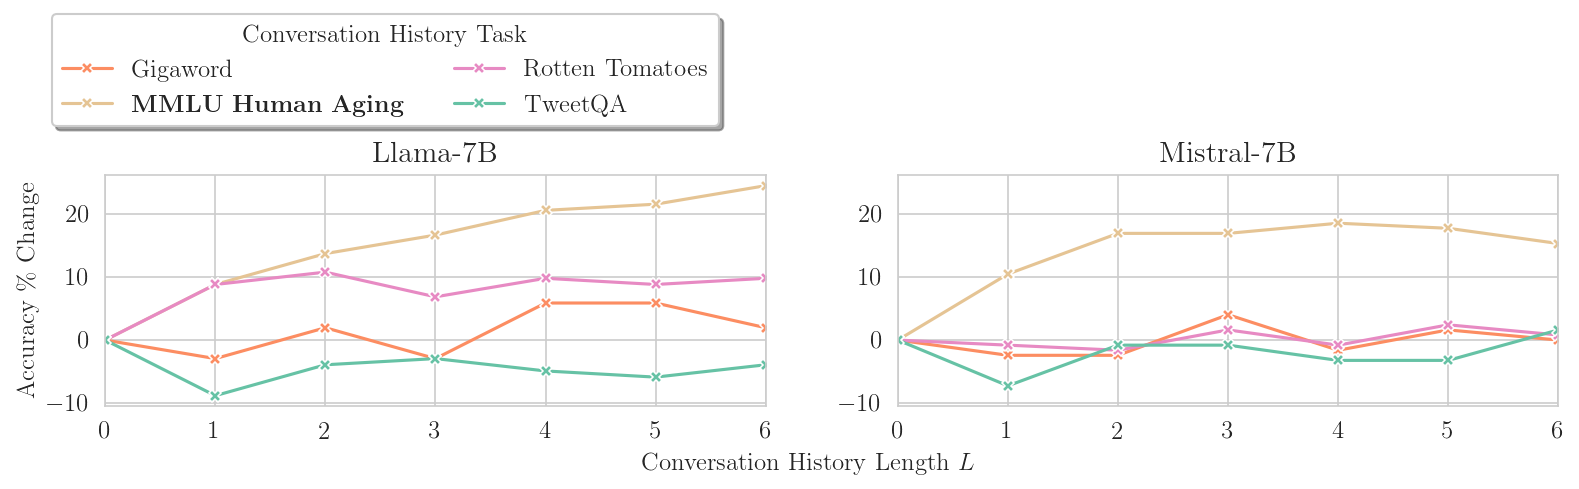

In [16]:
label = r"Accuracy \% Change"
df = ha_converse_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_anchor=(-1.3, 1.75),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)